In [21]:
import os, shutil
import random
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.applications import InceptionResNetV2
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

In [22]:
train_dir = 'data/train'
test_dir = 'data/test'

train_bears = ['data/train/{}'.format(i) for i in os.listdir(train_dir) if 'bear' in i]  #get bears images
train_cows = ['data/train/{}'.format(i) for i in os.listdir(train_dir) if 'cow' in i]  #get cows images
train_deers = ['data/train/{}'.format(i) for i in os.listdir(train_dir) if 'deer' in i]  #get deers images
train_hogs = ['data/train/{}'.format(i) for i in os.listdir(train_dir) if 'hog' in i]  #get hogs images
train_turkeys = ['data/train/{}'.format(i) for i in os.listdir(train_dir) if 'turkey' in i]  #get turkey images

test_imgs = ['data/test/{}'.format(i) for i in os.listdir(test_dir)] #get test images
train_imgs = train_bears + train_cows + train_deers + train_hogs + train_turkeys
random.shuffle(train_imgs)  # shuffle it randomly

#Clear list that are useless
del train_bears
del train_cows
del train_deers
del train_hogs
del train_turkeys
gc.collect()   #collect garbage to save memory

8

In [23]:
#Lets declare our image dimensions
#we are using coloured images. 
nrows = 150
ncolumns = 150
channels = 3  #change to 1 if you want to use grayscale image

In [24]:
#A function to read and process the images to an acceptable format for our model
def read_and_process_image(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        if image.endswith("jpg") or image.endswith("png"):
            X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
            #get the labels
            if 'bear' in image:
                y.append(0)
            elif 'cow' in image:
                y.append(1)
            elif 'deer' in image:
                y.append(2)
            elif 'hog' in image:
                y.append(3)
            elif 'turkey' in image:
                y.append(4)
    
    return X, y

In [ ]:
#get the train and label data
X, y = read_and_process_image(train_imgs)

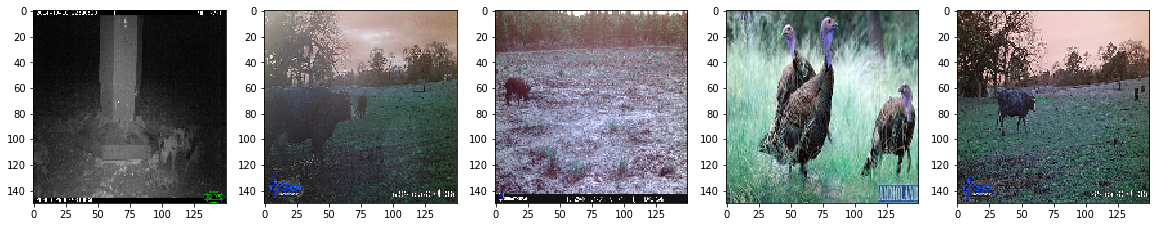

In [6]:
#Lets view some of the pics
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])

Text(0.5, 1.0, 'Labels for animals')

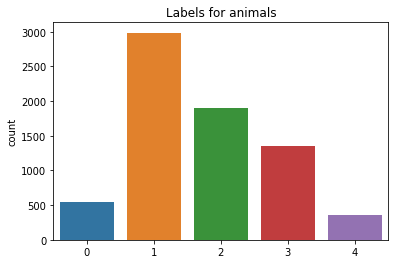

In [7]:
del train_imgs
gc.collect()
#Convert list to numpy array
X = np.array(X)
y = np.array(y)

#Lets plot the label to be sure we just have two class
sns.countplot(y)
plt.title('Labels for animals')

In [8]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (7156, 150, 150, 3)
Shape of labels is: (7156,)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

In [10]:
#clear memory
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32

In [11]:
conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [13]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

In [14]:
#Lets see our model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3539200   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 57,876,193
Trainable params: 57,815,649
Non-trainable params: 60,544
_________________________________________________________________


In [15]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 492
Number of trainable weights after freezing the conv base: 4


In [16]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [18]:
#Create the image generators
train_generator = train_datagen.flow(X_train, y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [19]:
#The training part
#We train for 64 epochs with about 100 steps per epoch
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=20,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
178/178 [==============================] - 408s 2s/step - loss: -9.7778 - acc: 0.4177 - val_loss: -11.1497 - val_acc: 0.4126
Epoch 2/20
178/178 [==============================] - 405s 2s/step - loss: -11.1159 - acc: 0.4172 - val_loss: -11.2409 - val_acc: 0.4107
Epoch 3/20
178/178 [==============================] - 405s 2s/step - loss: -11.2785 - acc: 0.4174 - val_loss: -10.8919 - val_acc: 0.4186
Epoch 4/20
178/178 [==============================] - 421s 2s/step - loss: -11.3366 - acc: 0.4205 - val_loss: -11.1238 - val_acc: 0.4186
Epoch 5/20
178/178 [==============================] - 452s 3s/step - loss: -11.3548 - acc: 0.4195 - val_loss: -11.3528 - val_acc: 0.4050
Epoch 6/20
178/178 [==============================] - 446s 3s/step - loss: -11.3814 - acc: 0.4163 - val_loss: -11.3077 - val_acc: 0.4136
Epoch 7/20
178/178 [==============================] - 425s 2s/step - loss: -11.4540 - acc: 0.4163 - val_loss: -11.0230 - val_acc: 0

In [20]:
#Save the model
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

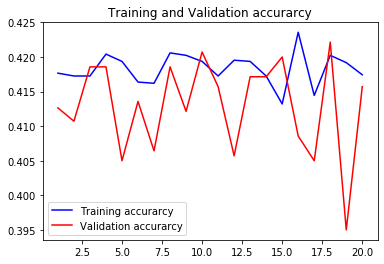

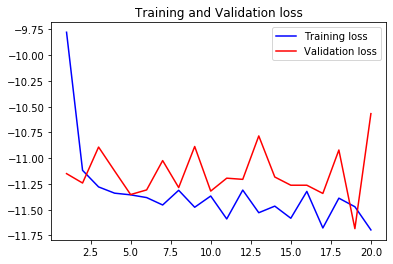

In [21]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [22]:
def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

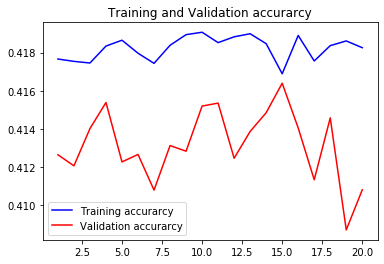

In [23]:
#Plot figure
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accurarcy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.show()

In [24]:
#Now lets predict on the first 10 Images of the test set
X_test, y_test = read_and_process_image(test_imgs[0:10]) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
i = 0
columns = 5
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    print(pred)
    if pred > 0.5:
        text_labels.append('dog')
    else:
        text_labels.append('cat')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()

NameError: name 'test_datagen' is not defined

<Figure size 2160x1440 with 0 Axes>